# <b><u> Project Title : Sentiment Analysis : Predicting sentiment of COVID-19 tweets</u></b>

## <b> Problem Description </b>

### This challenge asks you to build a classification model to predict the sentiment of COVID-19 tweets.The tweets have been pulled from Twitter and manual tagging has been done then.

### The names and usernames have been given codes to avoid any privacy concerns.

### You are given the following information:
1. Location
2. Tweet At
3. Original Tweet
4. Label

###Sentiment analysis studies the subjective information in an expression, that is, the opinions, appraisals, emotions, or attitudes towards a topic, person or entity. Expressions can be classified as positive, negative, or neutral.
###Twitter is one of the most powerful social media platform in the world right now , with 360 million monthly active users and around 500 million tweets sent each day. It is used every day by people to express opinions about different topics, such as products, movies, music, politicians, events, social events, among others.
###Coronavirus disease (COVID-19) is an infectious disease caused by the SARS-CoV-2 virus. It is a global pandemic that is still infecting millions of people around the world . In this project we will be looking at thousand of tweets made on Covid-19 from around the world and will try to predict the sentiment of each of the tweet by classifying them into three categories positive, negative and neutral.

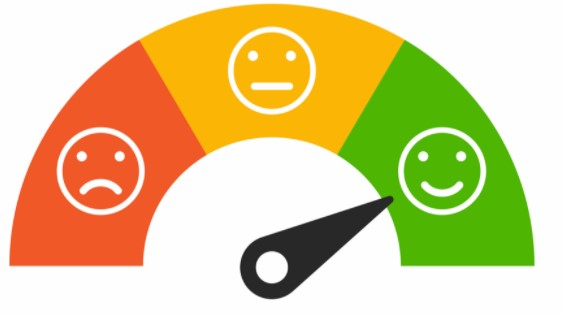

In [1]:
#Libraries for data manipulation
import pandas as pd
import numpy as np
#Libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.graph_objects as go
#Libraries to suppress warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Other libraries used
import re
import sys
import requests
from PIL import Image
import requests as r
from wordcloud import WordCloud
from collections import Counter
from collections import defaultdict

#Now let us mount the drive and load the dataset

In [3]:
#Mounting drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#Loading the dataset
tweet_df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/project/Coronavirus Tweet Sentiment Analysis/Coronavirus Tweets.csv',encoding="ISO-8859-1")

In [5]:
#Creating a copy of the dataset
df=tweet_df.copy()

In [6]:
#First look
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [7]:
#Checking basic information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [8]:
#Checking the shape of the dataset
print("The dataset contains",df.shape[0],"rows")
print("The dataset contains",df.shape[1],"columns")

The dataset contains 41157 rows
The dataset contains 6 columns


In [9]:
#Checking for duplicates
print("The number of duplicates are:",len(df[df.duplicated()]))

The number of duplicates are: 0


In [10]:
#Getting count of null values in all the columns
df.isnull().sum()

UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

####We can observe that only the column 'Location' contains null values. But we are not considering that column for sentiment analysis. Hence there is no need for null value treatment.


##Let's create a word cloud showing the different variables in the given dataset.

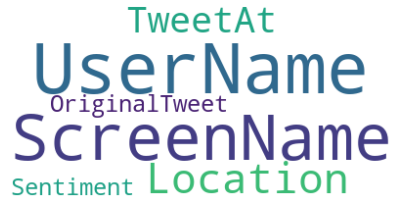

In [11]:
#Storing the column names to make a word cloud
plt.rcParams['figure.figsize']=7,7
text1 = " ".join(title for title in df.columns)
# Creating word_cloud with text as argument in .generate() method
word_cloud1 = WordCloud(collocations = False, background_color = 'white').generate(text1)
# Display the generated Word Cloud
plt.imshow(word_cloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

In [12]:
#Unique number of values in each column
df.nunique()

UserName         41157
ScreenName       41157
Location         12220
TweetAt             30
OriginalTweet    41157
Sentiment            5
dtype: int64

###It is clear that screenName and UserName are unique for each observation in the given dataset. Therefore we will remove them.

In [13]:
#Drop UserName and ScreenName
df.drop(["UserName","ScreenName"],axis=1,inplace=True)

#**Target variable analysis**

###Now, let's analyze the target variable, **Sentiment**

In [14]:
#Checking subcategories of target variable
df.Sentiment.unique()

array(['Neutral', 'Positive', 'Extremely Negative', 'Negative',
       'Extremely Positive'], dtype=object)

####We ave 5 subcategories for Sentiment, and they are '**Neutral**', '**Positive**', '**Extremely Negative**', '**Negative**' and '**Extremely Positive**'

In [15]:
#Analysing the number of tweets in each subcategory of target variable
df.Sentiment.value_counts()

Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

Text(0, 0.5, 'Number of tweets')

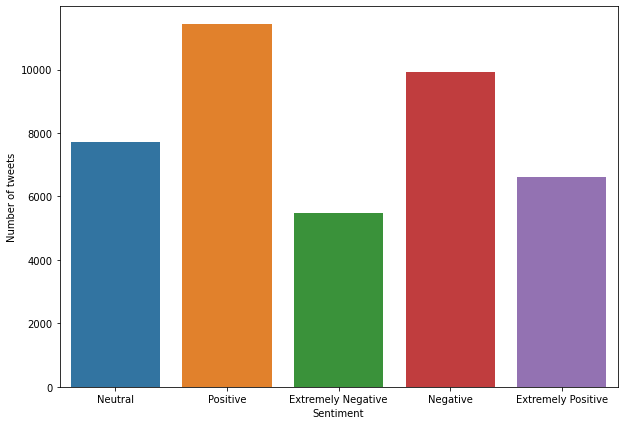

In [16]:
#Setting the heigt and width of the graph
plt.rcParams["figure.figsize"]=10,7
#Plotting the total number of tweets for each subcategory in the target variable
sns.countplot(x="Sentiment", data=df)
plt.ylabel("Number of tweets")

#Converting Sentiment 

####We will convert this 5-class classification problem into a 3-class classification problem by merging Extremely Positive tweets with positive tweets and Extremely Negative tweets with negative tweets.

In [17]:
def Sentiment_Grouping(sentiment):

  '''This function will combiner Extremely Positive tweets with Positive Category
     and Extremely Negative tweets with Negative Category'''

  if sentiment == "Extremely Positive":
    return "Positive"
  elif sentiment == "Extremely Negative":
    return "Negative"
  else:
    return sentiment

In [18]:
#Apply the Sentiment_Grouping function on the Sentiment column
df["Sentiment"] = df["Sentiment"].apply(Sentiment_Grouping)

In [19]:
df['Sentiment'].unique()

array(['Neutral', 'Positive', 'Negative'], dtype=object)

####The types of sentiments after grouping are:

####1.Neutral
####2.Positive
####3.Negative

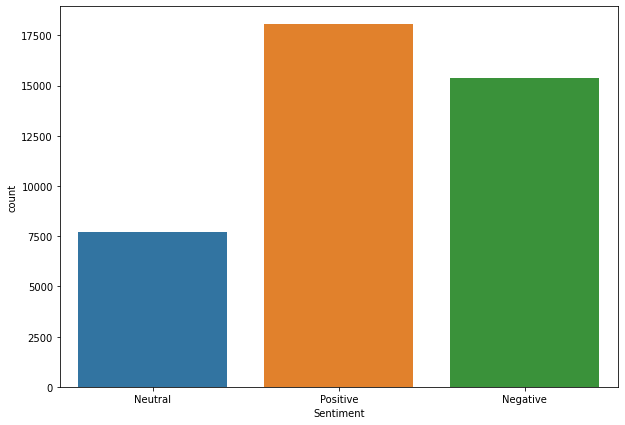

In [20]:
#Plotting the total number of tweets for each subcategory in the target variable after the transformation
plt.rcParams["figure.figsize"]=10,7
sns.countplot(x="Sentiment", data=df)

#Location Analysis

###Let us find out top 10 locations of tweet

In [21]:
#Getting total number of tweets tweeted from all the locations
loc=df['Location'].value_counts().reset_index()
loc.rename(columns={'index':"location","Location":"count"},inplace=True)
loc

,location,count
0,London,540
1,United States,528
2,"London, England",520
3,"New York, NY",395
4,"Washington, DC",373
...,...,...
12215,Staffordshire Moorlands,1
12216,Kithchener ON,1
12217,"Tulsa, Ok",1
12218,"Watford, South Oxhey, Bushey",1


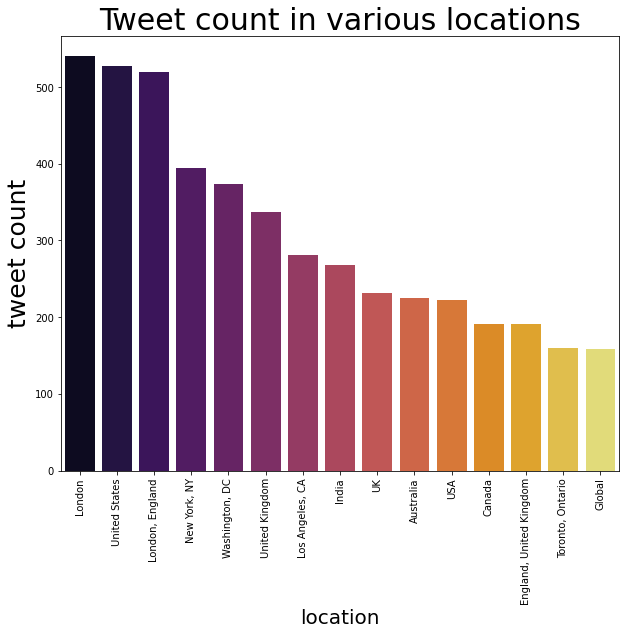

In [22]:
#Plotting number of tweets v/s location
plt.rcParams["figure.figsize"]=(10,8)
sns.barplot(loc["location"][0:15], x = 'location', y =loc["count"][0:15], palette ='inferno').tick_params(axis='x', rotation=90)
plt.title('Tweet count in various locations', fontsize = 30)
plt.xlabel('location', fontsize = 20)
plt.ylabel('tweet count', fontsize = 25)
plt.show()

###Most of the tweets are from United States, London and New York.

#Date Analysis

In [23]:
#Converting the TweetAt column to a datetime object
df["TweetAt"] = pd.to_datetime(df["TweetAt"])

In [24]:
#Obtaining the time period of the dataset 
print("Our dataset contains tweets from {}th {} {} to {}th {} {}".format(df["TweetAt"].min().day, df["TweetAt"].min().month_name(), df["TweetAt"].min().year,
         df["TweetAt"].max().day, df["TweetAt"].max().month_name(), df["TweetAt"].max().year))

Our dataset contains tweets from 4th January 2020 to 4th December 2020


##Extract day, month and day name

In [25]:
#Creating new column for day and month from date colum "TweetAt"
df['day'] = pd.DatetimeIndex(df['TweetAt']).day
df['month'] = pd.DatetimeIndex(df['TweetAt']).month
#Creating a column containing name of the weekday
df["week day"]=pd.DatetimeIndex(df['TweetAt']).day_name()

In [26]:
#Obtaining the bottom 5 rows of the dataset
df.tail()

,Location,TweetAt,OriginalTweet,Sentiment,day,month,week day
41152,"Wellington City, New Zealand",2020-04-14,Airline pilots offering to stock supermarket s...,Neutral,14,4,Tuesday
41153,NaN,2020-04-14,Response to complaint not provided citing COVI...,Negative,14,4,Tuesday
41154,NaN,2020-04-14,You know itÂs getting tough when @KameronWild...,Positive,14,4,Tuesday
41155,NaN,2020-04-14,Is it wrong that the smell of hand sanitizer i...,Neutral,14,4,Tuesday
41156,i love you so much || he/him,2020-04-14,@TartiiCat Well new/used Rift S are going for ...,Negative,14,4,Tuesday


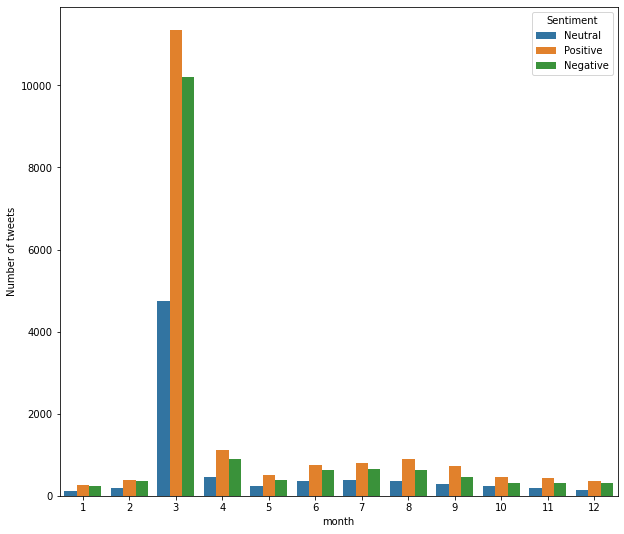

In [27]:
#Plotting total number of tweets for each sentiment over the months
plt.rcParams["figure.figsize"]=(10,9)
ax = sns.countplot(x="month", hue="Sentiment", data=df)
plt.ylabel("Number of tweets")
plt.show()

###It is clear the most number of tweets was created in the month of March.
###Let's analyze the tweet count on a daily basis in the month of March

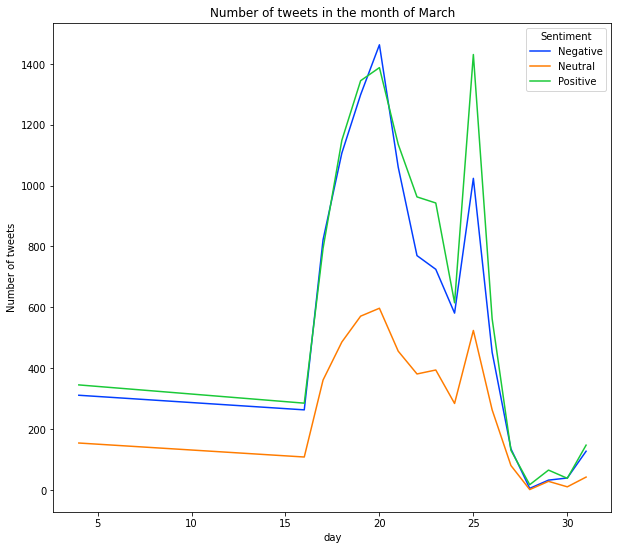

In [28]:
#Creating a subset of our dataframe that will only contains tweets from the month of march
day_analysis = df[df["month"] == 3].copy()
#Grouping our dataset on the basis of Day and sentiment to get the number of tweets tweeted on each day in the month of march belonging to each sentiment
daySentiment_groupby = day_analysis.groupby(["day" , "Sentiment"]).agg({ "OriginalTweet" : "count"}).reset_index()
sns.lineplot(x = "day" , y ="OriginalTweet" , hue="Sentiment" ,  data = daySentiment_groupby , palette = 'bright' )
plt.title("Number of tweets in the month of March")
plt.ylabel("Number of tweets")
plt.show()

###Let's check out the day when people tweet the most.

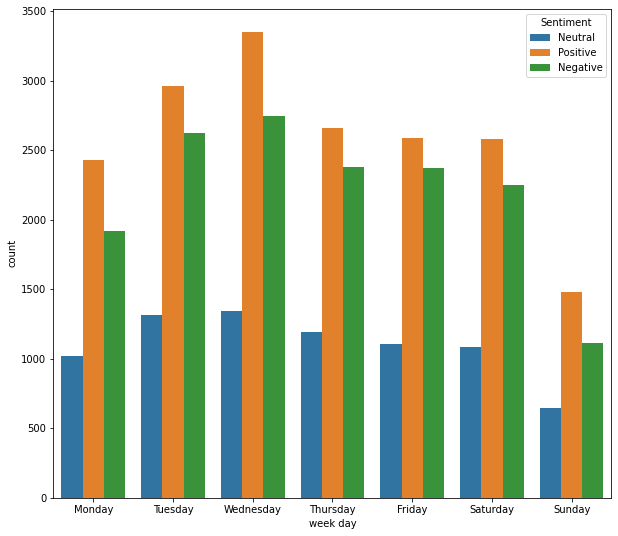

In [29]:
#Checking which day people are creating more tweets
ax = sns.countplot(x="week day", hue="Sentiment", data=df)

####We expected it to be the holiday that people tweet the most. But on Wednesday it was found that people were tweeting more. This may be the result of lockdown.

#Tweet length analysis

####Lets us try to get insights regarding tweet length.

In [30]:
#Creating a new column 'length' by calculating the length of tweets
df['length']=df['OriginalTweet'].apply(len)
df.head()

,Location,TweetAt,OriginalTweet,Sentiment,day,month,week day,length
0,London,2020-03-16,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,16,3,Monday,111
1,UK,2020-03-16,advice Talk to your neighbours family to excha...,Positive,16,3,Monday,237
2,Vagabonds,2020-03-16,Coronavirus Australia: Woolworths to give elde...,Positive,16,3,Monday,131
3,NaN,2020-03-16,My food stock is not the only one which is emp...,Positive,16,3,Monday,306
4,NaN,2020-03-16,"Me, ready to go at supermarket during the #COV...",Negative,16,3,Monday,310


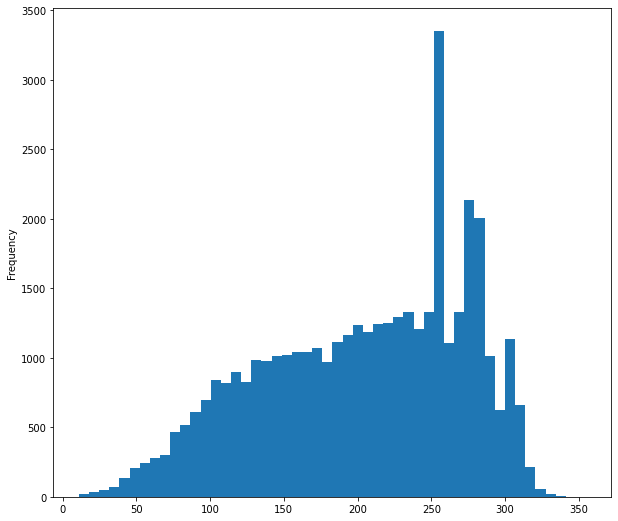

In [31]:
#Checking distribution of length of tweets
plt.rcParams["figure.figsize"]=(10,9)
df['length'].plot(bins=50,kind='hist')

In [32]:
def show_dist(df, col):

  '''Function is to show distribution of any particular column for each of the different sentiment'''

  bins = np.arange(df[col].min(), df[col].max() + 1)
  g = sns.FacetGrid(df, col='Sentiment', height=5, hue='Sentiment', palette="bright")
  g = g.map(sns.histplot, col, kde=False, bins=bins)

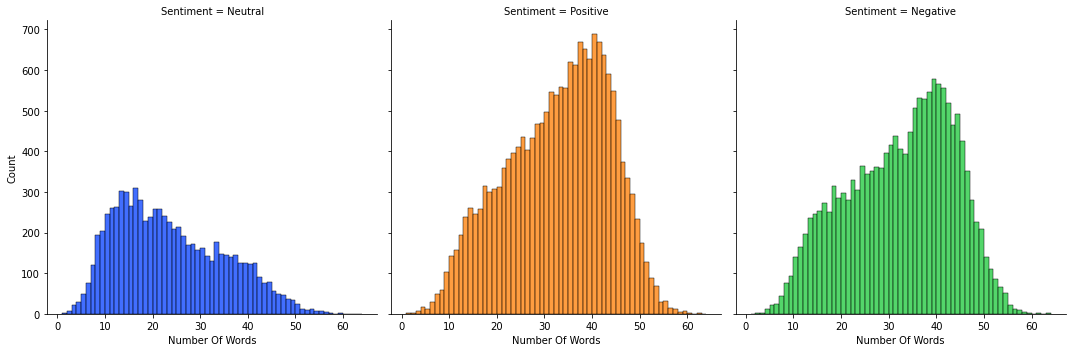

In [33]:
#Creating a new column named "Number Of Words" to store the number of words in each tweet
df["Number Of Words"] = df["OriginalTweet"].str.split().apply(len)
show_dist(df , 'Number Of Words')

####The number of words present in tweets of neutral sentiment is far less when compared to tweets with a positive or negative sentiment . Most of the positive and negative sentiment tweets contain almost 40 words on average.

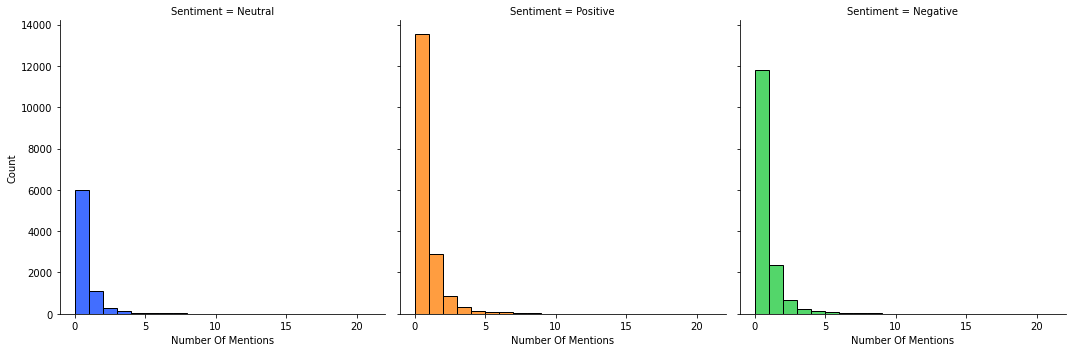

In [34]:
#Creating a new column named "Number Of Mentions" to store the number of mentions in each tweet
df["Number Of Mentions"] = df["OriginalTweet"].apply(lambda tweet : len(re.findall(r'@[^\s]+', tweet)))
show_dist(df, "Number Of Mentions")

####Most of the tweets contain no mention and there is no particular relationship between number of mentions and regard the sentiment.

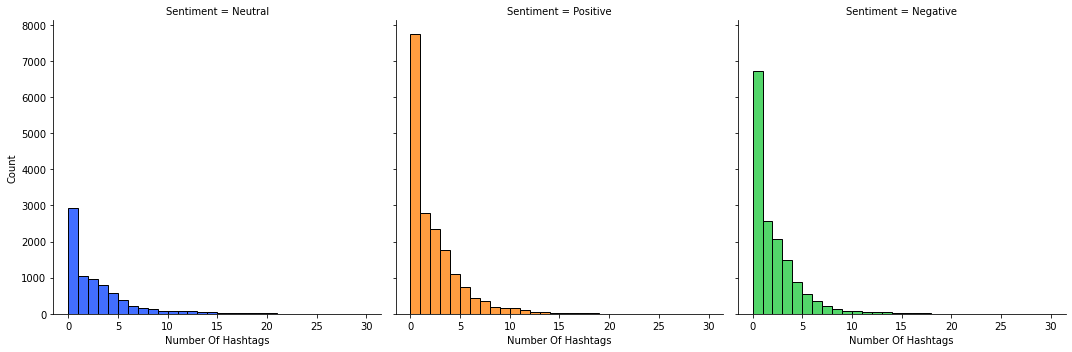

In [35]:
#Creating a new columns named "Number Of Hashtags" to store the number of hastags in each tweet
df["Number Of Hashtags"] = df["OriginalTweet"].apply(lambda tweet : len(re.findall(r'#[^\s]+', tweet)))
show_dist(df, "Number Of Hashtags")

####Most tweets do not have a hashtag. Again, the number of hashtags has nothing to do with the sentiment.

#Extract hashtags

####Let's now try to understand the impact of hashtags on tweets sentiment

In [36]:
def extract_hash_tags(s):
  return [part[1:] for part in s.split() if part.startswith('#')]
df['hashtags']=df['OriginalTweet'].apply(extract_hash_tags)

In [37]:
df.head()

,Location,TweetAt,OriginalTweet,Sentiment,day,month,week day,length,Number Of Words,Number Of Mentions,Number Of Hashtags,hashtags
0,London,2020-03-16,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,16,3,Monday,111,8,3,0,[]
1,UK,2020-03-16,advice Talk to your neighbours family to excha...,Positive,16,3,Monday,237,38,0,0,[]
2,Vagabonds,2020-03-16,Coronavirus Australia: Woolworths to give elde...,Positive,16,3,Monday,131,14,0,0,[]
3,NaN,2020-03-16,My food stock is not the only one which is emp...,Positive,16,3,Monday,306,42,0,7,"[COVID19france, COVID_19, COVID19, coronavirus..."
4,NaN,2020-03-16,"Me, ready to go at supermarket during the #COV...",Negative,16,3,Monday,310,40,0,6,"[COVID19, coronavirus, CoronavirusFrance, rest..."


In [38]:
#Creating a new dataframe containing hashtags and their count
d = Counter(df.hashtags.sum())
hashtags= pd.DataFrame([d]).T

In [39]:
#Renaming the columns and resetting the index
hashtags.rename_axis('hashtag',inplace=True)
hashtags.rename(columns={0:"Count"},inplace=True)
hashtags=hashtags.reset_index()

In [40]:
#Sorting the hashtags based on their count
hashtags.sort_values(by='Count',ascending=False,inplace=True)

In [41]:
#Checking the dataframe
hashtags

,hashtag,Count
3,coronavirus,12224
2,COVID19,3204
10,Covid_19,2469
53,Coronavirus,2068
26,COVID2019,1588
...,...,...
8504,WhoDidThis,1
8505,expensive,1
8507,PTCares,1
8508,vlogger,1


In [42]:
#Creating a pie plot to show the top 10 hashtag and their relative percentage share among themselves
data = {
   "values": hashtags['Count'][:10],
   "labels": hashtags["hashtag"][:10],
   "domain": {"column": 0},
   "name": "hashtags",
   "hoverinfo":"label+percent+name",
   "hole": .4,
   "type": "pie"
}
#Providing title for the plot
layout = go.Layout(title="<b>Relative Percentage of top 10 Hashtag</b>", legend=dict(x=0.9, y=0.8, orientation="v"))
#Ploting
data = [data]
fig = go.Figure(data = data, layout = layout)
fig.update_layout(title_x=0.5)
fig.show()

####"Coronavirus" is the most used hashtag.


###Let's create a word cloud to visualize the hashtags

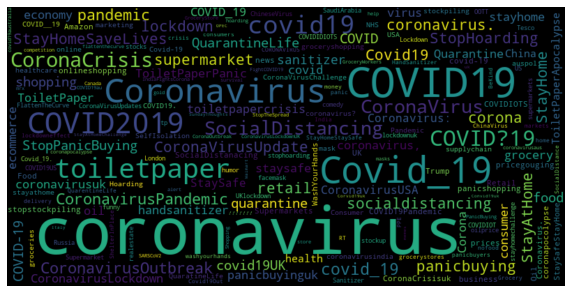

In [43]:
#Creating a dictionary containing hash tag and it's count
data = dict(zip(hashtags['hashtag'].tolist(), hashtags['Count'].tolist()))
#Generate word cloud of hash tags based on their frequency
wc = WordCloud(width=800, height=400, max_words=200,background_color = 'black').generate_from_frequencies(data)
#Providing figure size
plt.figure(figsize=(10, 10))
#plotting
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()


In [44]:
df.head()

,Location,TweetAt,OriginalTweet,Sentiment,day,month,week day,length,Number Of Words,Number Of Mentions,Number Of Hashtags,hashtags
0,London,2020-03-16,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,16,3,Monday,111,8,3,0,[]
1,UK,2020-03-16,advice Talk to your neighbours family to excha...,Positive,16,3,Monday,237,38,0,0,[]
2,Vagabonds,2020-03-16,Coronavirus Australia: Woolworths to give elde...,Positive,16,3,Monday,131,14,0,0,[]
3,NaN,2020-03-16,My food stock is not the only one which is emp...,Positive,16,3,Monday,306,42,0,7,"[COVID19france, COVID_19, COVID19, coronavirus..."
4,NaN,2020-03-16,"Me, ready to go at supermarket during the #COV...",Negative,16,3,Monday,310,40,0,6,"[COVID19, coronavirus, CoronavirusFrance, rest..."


In [45]:
#Creating subsets of the dataframe based on sentiment category Positive, Negative and Neutral
Positive_tweet = df[df["Sentiment"] == "Positive"]
Negative_tweet = df[df["Sentiment"] == "Negative"]
Neutral_tweet = df[df["Sentiment"] == "Neutral"]

In [46]:
def hashtag_freq_graph(df):
  '''This function gives the frequency bar graph of the hashtags'''
  
  #Extracting hashtags from tweets
  df['hashtag'] = df['OriginalTweet'].apply(lambda twt : re.findall(r"#(\w+)", twt))
  #Taking value count on hashtags
  hashtags=df.OriginalTweet.str.extractall(r'(\#\w+)')[0].value_counts().reset_index()
  #renaming the columns
  hashtags.rename(columns={'index':"hashtag",0:'freq'},inplace=True)

  #Keeping only 15  most frequently used hashtags 
  hashtags=hashtags[:15]
  #Seting figuresize
  sns.set(rc = {'figure.figsize':(15,8)})
  #Ploting frequency against hashtag
  sns.barplot(x="hashtag" , y ="freq" , data = hashtags , palette = "bright")
  plt.xticks(rotation=45)
  plt.show()

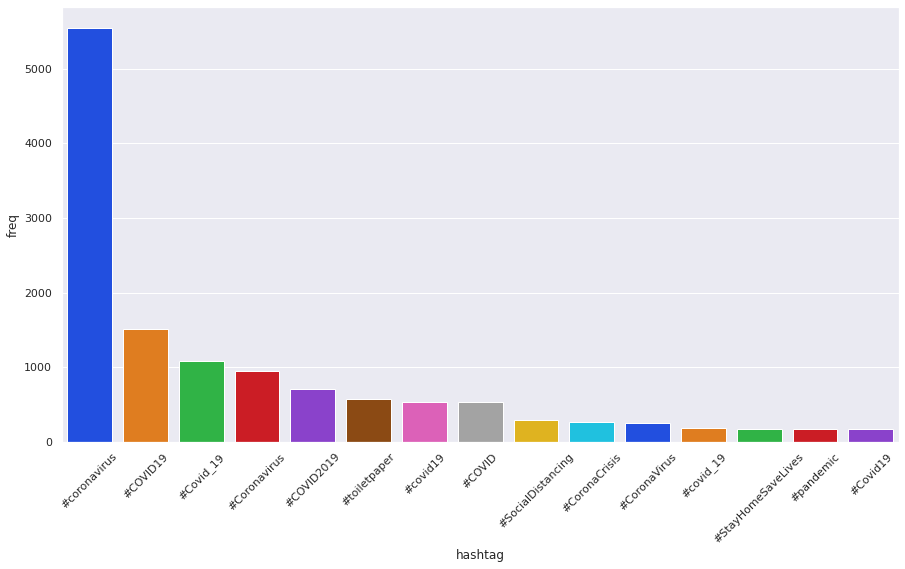

In [47]:
#Calling hashtag_freq_graph on positive tweet dataframe
hashtag_freq_graph(Positive_tweet)

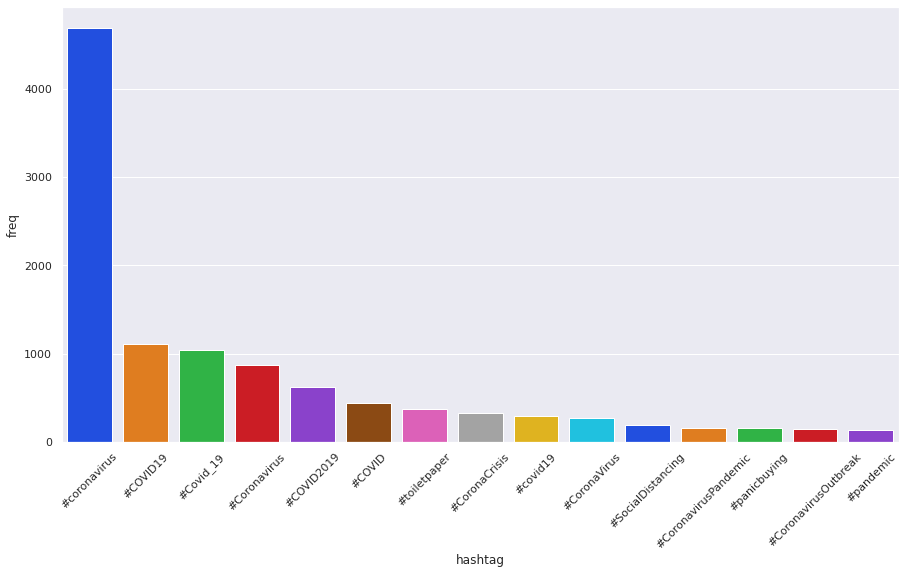

In [48]:
#Calling hashtag_freq_graph on negative tweet dataframe
hashtag_freq_graph(Negative_tweet)

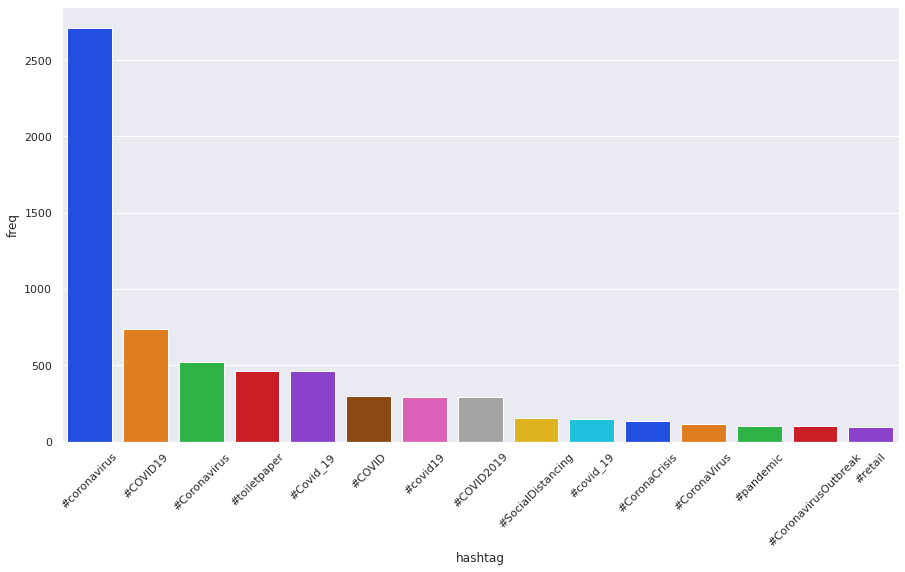

In [49]:
#Calling hashtag_freq_graph on neutral tweet dataframe
hashtag_freq_graph(Neutral_tweet)

####By looking at the bar graphs for positive and negative sentiment we can conclude that the hastags like #StayHomesaveLives are much more used in tweets of positive sentiment as compared to the negative sentiment tweets on the other hand hashtags like #panicbuying are more frequently used in negative sentiment tweets.

#**Tokenization**

###Tokenization is the term used to describe the process of converting the normal text strings in to a list of tokens.


In [50]:
#Importing Libraries for NLP
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk import word_tokenize
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob

##Remove user names, links, symbols and numbers from the tweet

In [51]:
def clean_tweets(tweet):
    #Removes usernames
    tweet = re.sub('@[^\s]+','',tweet)
    #Removes links
    tweet = re.sub('http[^\s]+','',tweet)
    #Removes numbers
    tweet = re.sub(r'\d+','',tweet)
    #Removes special characters
    tweet = re.sub('[^a-zA-Z0-9\s]+','',tweet)
    return tweet

df['cleaned tweet'] = df['OriginalTweet'].apply(clean_tweets)

##Expanding the contractions

####Contraction is an abbreviated form of a word, like don't stand for do not. This contraction in the text data needs to be expanded for better analysis. It will match the word with the keys, and if it exists it will replace the word with its value.

In [52]:
#Installing contractions  
!pip install contractions
!{sys.executable} -m pip install contractions
import contractions

In [53]:
def contractions_remover(text):
  '''Tis function fixes contractions'''
# creating an empty list
  expanded_words = []    
  
  for word in text.split():
    # using contractions.fix to expand the shotened words
    expanded_words.append(contractions.fix(word))   
 
  #joining words    
  expanded_text = ' '.join(expanded_words)
  return expanded_text
  
#Applying the function contraction remover on the column cleaned tweet
df["cleaned tweet"] = df["cleaned tweet"].apply(contractions_remover)

#Remove punctuations and stopwords

####Stopwords are those commonly used words that are often added to sentences to make them grammatically correct.They do not add any values to our analysis as these words carry less or no meaning as far as churning out information about the sentiment is concerned.

In [54]:
#Downloading stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [55]:
#Storing the set of stopwords in Enlish
stop_words = set(stopwords.words('english'))
print("The stop words in English are",stop_words)

#Creating a whitelist of stopwords we need to keep as they affect the sentiment
whitelist = ["n't", "not", "no" , "nor" , "couldn't" , "wouldn't" ,"isn't" , "haven't" , "wasn't" , "didn't" , "hasn't" , "shouldn't" , "doesn't" , "weren't" ,
              "aren't"]
              
#Creating a list of stopwords which does not contain our whitelist              
stops=[item for item in stop_words if item not in whitelist]
print("The required stopwords are",stops)

The stop words in English are {'theirs', 'only', 'just', 'against', "mightn't", 'did', "you'd", 'has', 'won', 'doing', 'how', 'my', "that'll", 'off', 'there', 'each', 'if', 'because', 'itself', 'yourselves', 'hers', 'o', "wouldn't", 'to', 'are', 'himself', 'do', 'too', 'be', 'few', 'hasn', 'shouldn', 'is', 'where', 'i', 'wasn', "didn't", 'll', 'me', 'while', 'they', 'up', 'now', 't', 'as', 'when', "shouldn't", 'most', 'd', 'over', "wasn't", 'the', 'hadn', 'y', 'about', 'not', 'why', 'under', 'more', 'some', 'down', 'weren', 'its', 'does', 'isn', 'myself', 'yourself', 'same', 'aren', "doesn't", 'nor', 'then', 'am', 'at', 'through', 're', 'in', 'you', 'she', 'which', 'very', 'should', 'ain', "you've", 'such', 'were', 'mustn', 'below', 'further', 'her', 'shan', 'on', 'can', 'we', 'no', 'yours', 'wouldn', 'ours', 'them', 'an', 'by', "hasn't", 'from', 'but', 'haven', 'those', "aren't", 'don', "isn't", "shan't", 'both', 'being', 'him', "should've", 'here', 'couldn', 'didn', 'had', "mustn't",

In [56]:
def text_process(msg):
    '''This function removes punctuations and stopwords from sentences'''
    
    #Storing characters other than punctuations from sentences
    nopunc =[char for char in msg if char not in string.punctuation]
    nopunc=''.join(nopunc)

    #Creating a list of all the words that are not stopwords or are present in whitelist and then joining them to return a sentence
    return ' '.join([word.lower() for word in nopunc.split() if word.lower() not in stops])

In [57]:
#Applying the function text_process on the column cleaned tweet
df['cleaned tweet'] = df['cleaned tweet'].apply(text_process)

In [58]:
df.tail()

,Location,TweetAt,OriginalTweet,Sentiment,day,month,week day,length,Number Of Words,Number Of Mentions,Number Of Hashtags,hashtags,cleaned tweet
41152,"Wellington City, New Zealand",2020-04-14,Airline pilots offering to stock supermarket s...,Neutral,14,4,Tuesday,102,12,0,2,"[NZ, COVID-19]",airline pilots offering stock supermarket shel...
41153,NaN,2020-04-14,Response to complaint not provided citing COVI...,Negative,14,4,Tuesday,138,23,0,0,[],response complaint not provided citing covid r...
41154,NaN,2020-04-14,You know itÂs getting tough when @KameronWild...,Positive,14,4,Tuesday,136,18,2,2,"[coronavirus, toiletpaper]",know getting tough rationing toilet paper coro...
41155,NaN,2020-04-14,Is it wrong that the smell of hand sanitizer i...,Neutral,14,4,Tuesday,111,18,0,3,"[coronavirus, COVID19, coronavirus]",wrong smell hand sanitizer starting turn coron...
41156,i love you so much || he/him,2020-04-14,@TartiiCat Well new/used Rift S are going for ...,Negative,14,4,Tuesday,255,46,1,0,[],well newused rift going amazon rn although nor...


# Lemmatization

###A method that switches any kind of a word to its base root mode is called Lemmatization.It will help us to diminish the number of tokens and hence boost up the entire method.

In [59]:
#Downloading packages for Lemmatization
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [60]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [61]:
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
  word_list = word_tokenize(text)
  lemmatized_string = ' '.join([lemmatizer.lemmatize(w , get_wordnet_pos(w)) for w in word_list])
  return lemmatized_string

In [62]:
print("Before lemmetization")
df["cleaned tweet"] [6]

Before lemmetization


'cashier grocery store sharing insights covid prove credibility commented civics class know talking'

In [63]:
#Applying the function lemmatize_text on cleaned_tweet column
df["cleaned tweet"] = df["cleaned tweet"].apply(lemmatize_text)

In [64]:
print("After lemmetization")
df["cleaned tweet"] [6]

After lemmetization


'cashier grocery store share insight covid prove credibility comment civics class know talk'

In [65]:
df.head()

,Location,TweetAt,OriginalTweet,Sentiment,day,month,week day,length,Number Of Words,Number Of Mentions,Number Of Hashtags,hashtags,cleaned tweet
0,London,2020-03-16,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,16,3,Monday,111,8,3,0,[],
1,UK,2020-03-16,advice Talk to your neighbours family to excha...,Positive,16,3,Monday,237,38,0,0,[],advice talk neighbour family exchange phone nu...
2,Vagabonds,2020-03-16,Coronavirus Australia: Woolworths to give elde...,Positive,16,3,Monday,131,14,0,0,[],coronavirus australia woolworth give elderly d...
3,NaN,2020-03-16,My food stock is not the only one which is emp...,Positive,16,3,Monday,306,42,0,7,"[COVID19france, COVID_19, COVID19, coronavirus...",food stock not one empty please not panic enou...
4,NaN,2020-03-16,"Me, ready to go at supermarket during the #COV...",Negative,16,3,Monday,310,40,0,6,"[COVID19, coronavirus, CoronavirusFrance, rest...",ready go supermarket covid outbreak not parano...


#Tweet Analysis

###For visualization purpose, let's create word clouds with words in positive, negative and neutral tweets

In [66]:
def word_cloud(df):

  "Function to show wordcloud for any textual column"

  # storing words from all tweets
  all_words = ' '.join([text for text in df['cleaned tweet'] ])

  #Storing the url of the image that we will use to mask wordcloud
  url = "https://images2.imgbox.com/e0/3c/d7SAy9mI_o.png"

  img = Image.open(requests.get(url, stream=True).raw)

  # converting PIL images into NumPy arrays
  virusMask = np.array(img)
  
  #Generating word cloud by providing parameters
  wordcloud = WordCloud(width=2000, height=1000, max_font_size=200, 
                            background_color="white", max_words=2000, mask = virusMask, 
                            contour_width=1, contour_color="steelblue", 
                            colormap="nipy_spectral").generate(all_words)
  
  plt.figure(figsize=(13, 11))
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.axis('off')
  

In [67]:
#Creating subsets of the dataframe based on sentiment category Positive, Negative and Neutral
Positive_tweet = df[df["Sentiment"] == "Positive"]
Negative_tweet = df[df["Sentiment"] == "Negative"]
Neutral_tweet = df[df["Sentiment"] == "Neutral"]

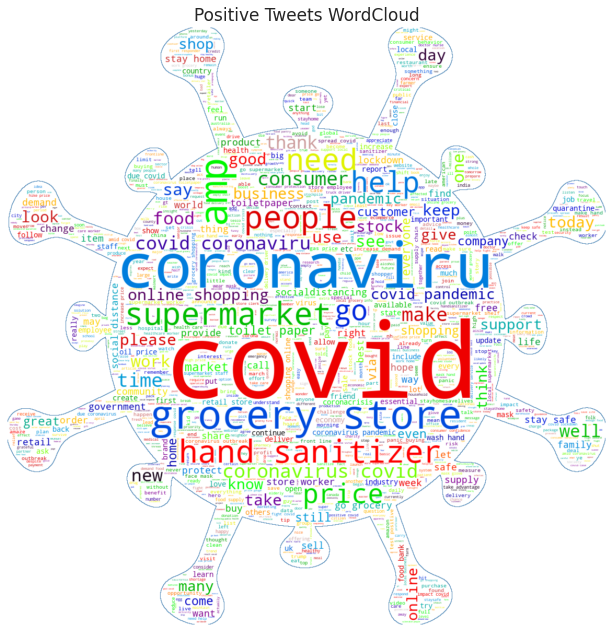

In [68]:
#Creating a word cloud with words in positive tweets
word_cloud(Positive_tweet)
plt.title("Positive Tweets WordCloud", fontsize=17)
plt.show()

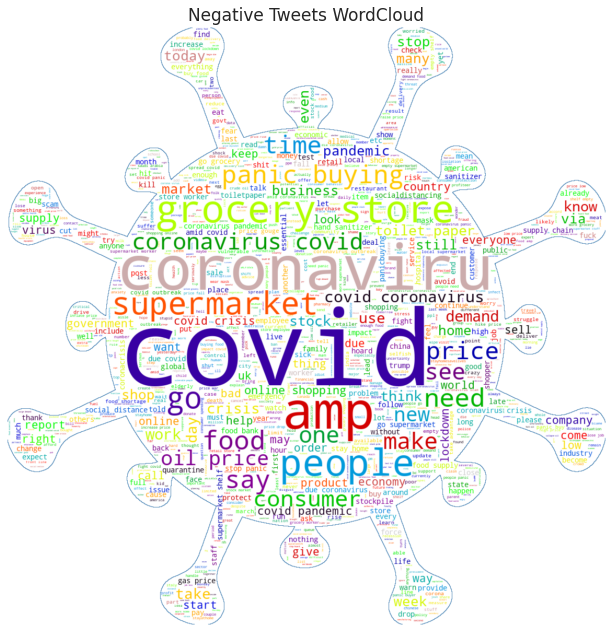

In [69]:
#Creating a word cloud with words in negative tweets
word_cloud(Negative_tweet)
plt.title("Negative Tweets WordCloud", fontsize=17)
plt.show()

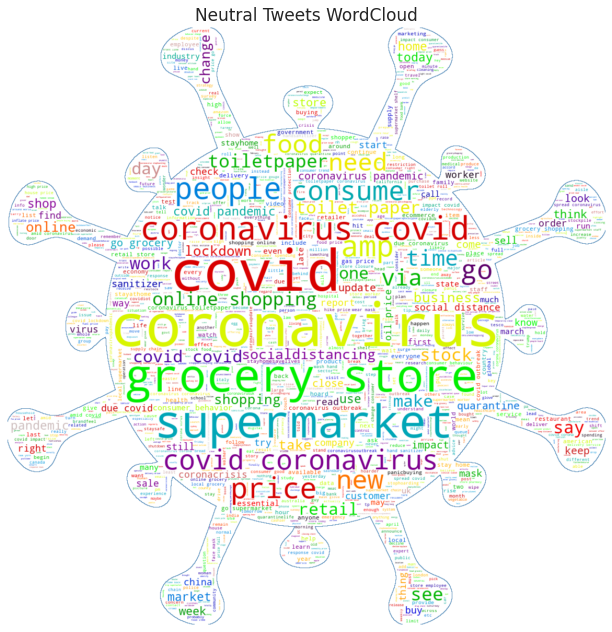

In [70]:
#Creating a word cloud with words in neutral tweets
word_cloud(Neutral_tweet)
plt.title("Neutral Tweets WordCloud", fontsize=17)
plt.show()

##Now, let's try to analyze the most frequently used words in positive, negative and neutral tweets.

In [71]:
#Vectorization for Data Visualization
def vectorization(table , col):

    '''Function to calculate the number of each word from a given column of a dataframe'''
    from sklearn.feature_extraction.text import CountVectorizer
    vector = CountVectorizer()

    frequency_matrix = vector.fit_transform(table[col])
    sum_frequencies = np.sum(frequency_matrix, axis=0)

    frequency = np.squeeze(np.asarray(sum_frequencies))
    frequency_df = pd.DataFrame([frequency], columns=vector.get_feature_names_out()).transpose()
    return frequency_df

In [72]:
def word_freq_map(dataframe):

  dataframe.reset_index(inplace=True)
  #Renaming the columns of our dataframe
  dataframe.rename(columns = {'index': "Word" , 0 : "Frequency"} , inplace = True)

  #Sorting our PosFrequency dataset by Frequency values so that we have the top 15 most frequent words present in tweets of positive sentiment
  dataframe = dataframe.sort_values(by = "Frequency" , ascending = False )[:15]

  sns.set(rc = {'figure.figsize':(15,8)})
  sns.barplot(x="Word" , y ="Frequency" , data = dataframe , palette = "bright")

  plt.xticks(rotation=45)
  plt.xlabel("Words", fontsize=15)
  plt.ylabel("Frequency", fontsize=15)
  

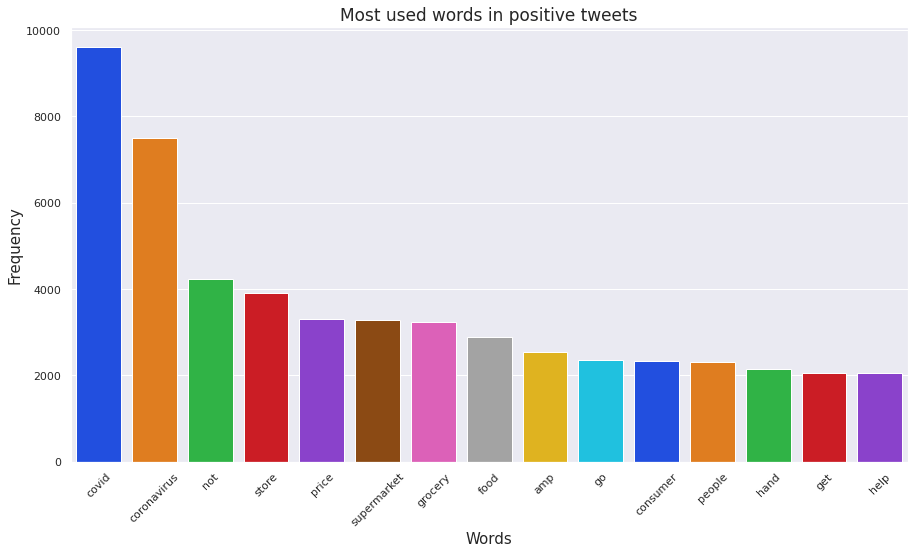

In [73]:
#Calling the function wrod_freq_map up on positive tweets
Posfrequency_df = vectorization(Positive_tweet, "cleaned tweet")
plt.title("Most used words in positive tweets", fontsize=17)
word_freq_map(Posfrequency_df)

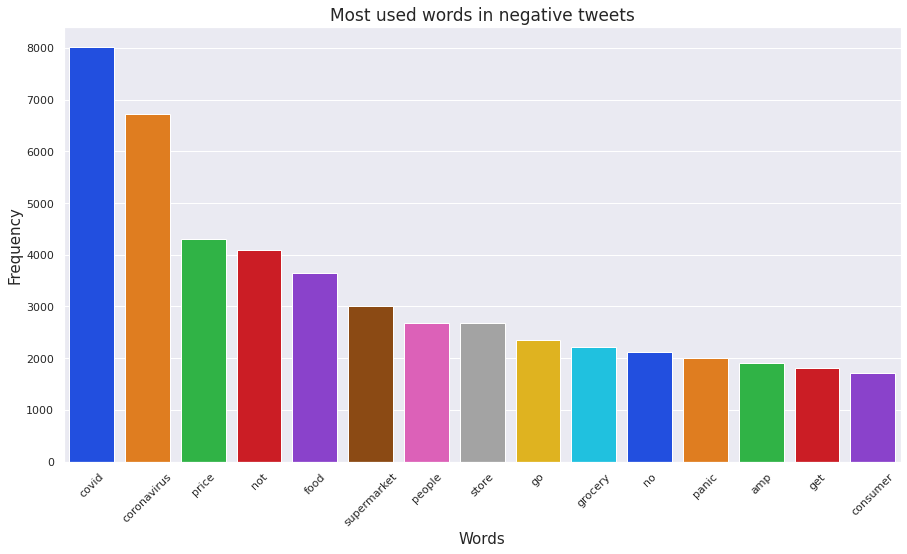

In [74]:
#Calling the function wrod_freq_map up on negative tweets
Negfrequency_df = vectorization(Negative_tweet, "cleaned tweet")
plt.title("Most used words in negative tweets", fontsize=17)
word_freq_map(Negfrequency_df)

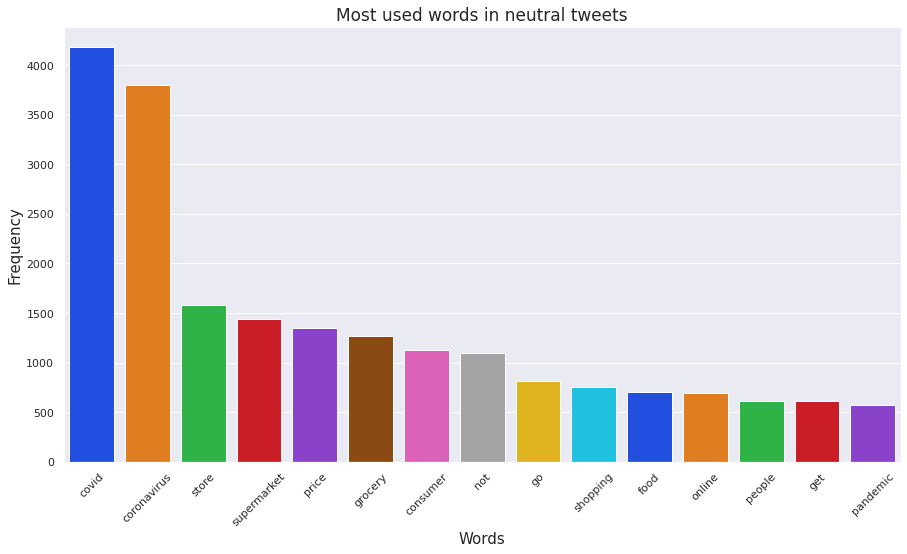

In [75]:
#Calling the function wrod_freq_map up on neutral tweets
Neutral_frequency_df = vectorization(Neutral_tweet, "cleaned tweet")
plt.title("Most used words in neutral tweets", fontsize=17)
word_freq_map(Neutral_frequency_df)

####1. There are relatively more mentions of words like store, grocery in positive tweets as compared to negative tweets 
####2. Panic is in list of top 15 words present in negative tweets but it is absent from the list of positive tweets whereas shopping is in list of top 15 words present in positive tweets but it is absent from negative tweets' top 15 words list

In [76]:
#Library for vectorization
from sklearn.feature_extraction.text import TfidfVectorizer
#Library for train test split
from sklearn.model_selection import train_test_split

#Libraries to import models
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

#Libraries for model evaluation
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.metrics import accuracy_score , precision_score, recall_score, f1_score

#Library for crossvalidation and yperparameter tuning
from sklearn.model_selection import GridSearchCV 

#Converting Sentiment

####We will convert the target variable into numeric form by giving labels 1 for positive tweets, 0 for neutral tweets and -1 for negative tweets.

In [77]:
#label encoding
encoders_nums = {"Sentiment":{"Positive":1,
                              "Neutral":0,
                             "Negative":-1}} 
#Converting target variable categories in to numbers                                    
df = df.replace(encoders_nums)

#**Vectorization(TFIDF)**

####To make the text data machine readable, we convert words into corresponding vectors of real numbers with the help of TFIDF Vectorizer.

In [78]:
# create the instance of count vectorizer 
vectorizer = TfidfVectorizer(max_df=.90,min_df=10)

In [79]:
#fit the vectorizer on the text data and convert it into an array
X = vectorizer.fit_transform(df["cleaned tweet"]).toarray()
#Storing target variable
y = df["Sentiment"]

## <b>Training a model using TFIDF vectorization</b>

#### Firstly we will do the usual train test split

In [80]:
#Performing train test split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=1,stratify=y)

In [81]:
#Checking shape of the train set
print("The shape of the train dataset is:",X_train.shape)

The shape of the train dataset is: (32925, 5198)


In [82]:
#Checking shape of the test set
print("The shape of the test dataset is:",X_test.shape)

The shape of the test dataset is: (8232, 5198)


####Now, the dataset is ready for applying different classification models.

#Evaluation

In [83]:
def Improved_cf_multiclass(cf_matrix):
  '''This function takes the confusion matrix as input and provides a labeled heatmap of the confusion matrix.'''
  #Defining labels
  group_names = [ "True Neg" ,"False Neutral" ,"False Pos" ,"False Neg","True Neutral" ,"False Pos","False Neg", "False Neutral" ,"True Pos"]
  #Flattening the 3D array to one dimension
  group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
  #Zipping curresponding label and value 
  labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_counts)]
  #Reshaping back to 3D array
  labels = np.asarray(labels).reshape(3,3)
  
  #Creating a heatmap for the given confusion matrix with labels created
  ax = sns.heatmap(cf_matrix , annot=labels, fmt='', cmap='Blues')
  #Set title, x-label and y-label
  ax.set_title('Seaborn Confusion Matrix with labels\n\n');
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values ');
  #Setting x-ticks and y-ticks
  ax.xaxis.set_ticklabels(['-1','0',"1"])
  ax.yaxis.set_ticklabels(['-1','0',"1"])
  #show the heatmap
  plt.show()


In [84]:
#Creating a list of evalation metrics
scoring_list = [accuracy_score , precision_score, recall_score , f1_score]

In [85]:
def classification_results(Y_true, Y_pred , scoring_list , average = None  ):

  '''Function to evaluate our model after training using different types
  of regression evaluation metrics and show all in a dataframe '''
  #Creating a deafult dictionary
  evaluation_dict = defaultdict(list)
  
  for count, scoring_metric in enumerate(scoring_list):
    #Appending the scoring metric's names to the dictionary
    evaluation_dict["scoring"].append(scoring_metric.__name__)
    
    #For accuracy score average=None
    if count == 0 or average is None:
      metric_value = scoring_metric((Y_true), (Y_pred))
    else:
      #For other metrics average=average
      metric_value = scoring_metric((Y_true), (Y_pred) , average = average )
    
    #Appending the value of the curresponding metric to the dictionary
    evaluation_dict["Value"].append('{:f}'.format(metric_value))
  
  #Creating a dataframe from the dictionary
  evaluation_df = pd.DataFrame(evaluation_dict)
  return evaluation_df

#MultinomialNB

###Here, we are using Multinomial Naive Bayes as our baseline  model.

In [86]:
#Creating an instance of the model MultinomialNB
model = MultinomialNB()
#Fitting the model on the train dataset
model.fit(X_train,y_train)

#Making prediction on our train and test dataset
nb_pred_train = model.predict(X_train)
nb_pred_test = model.predict(X_test)

#Storing train and test accuracy scores
nb_train_accuracy=accuracy_score(y_train,nb_pred_train)
nb_test_accuracy=accuracy_score(y_test,nb_pred_test)

#printing train and test accuracy scores
print("Training accuracy Score    : ", model.score(X_train,y_train))
print("Test accuracy Score : ", nb_test_accuracy )

#printing classification report for the performance of train and test set
print("\n","Naive Bayes-Classification Report for train dataset","\n")
print(classification_report(y_train,nb_pred_train))
print("Naive Bayes-Classification Report for test dataset","\n")
print(classification_report(y_test,nb_pred_test))

Training accuracy Score    :  0.7241609719058466
Test accuracy Score :  0.6722546161321672

 Naive Bayes-Classification Report for train dataset 

              precision    recall  f1-score   support

          -1       0.76      0.77      0.77     12318
           0       0.83      0.27      0.41      6170
           1       0.69      0.88      0.77     14437

    accuracy                           0.72     32925
   macro avg       0.76      0.64      0.65     32925
weighted avg       0.74      0.72      0.70     32925

Naive Bayes-Classification Report for test dataset 

              precision    recall  f1-score   support

          -1       0.70      0.72      0.71      3080
           0       0.71      0.19      0.30      1543
           1       0.65      0.84      0.73      3609

    accuracy                           0.67      8232
   macro avg       0.69      0.58      0.58      8232
weighted avg       0.68      0.67      0.64      8232



####In the classification report we can notice that the recall value for neutral labels are very low which means that the model is performing bad when it comes to correctly classifying neutral labels as it is wrongly classifying them into positives and negative sentiment tweets.

In [87]:
#Evaluating performance of prediction on the test data using different evalation metrics
naive_evaluation_df = classification_results(y_test,nb_pred_test, scoring_list , "macro" )
print("Performance of Naive Bayes model on the test dataset is:",'\n')
naive_evaluation_df

Performance of Naive Bayes model on the test dataset is: 



,scoring,Value
0,accuracy_score,0.672255
1,precision_score,0.686899
2,recall_score,0.582083
3,f1_score,0.579871


####We have got an accuracy score of 0.67 and all the other metrics scores below 0.68. 
####Therefore, the performance of  Naive Bayes is poor in this case.

#Stochastic Gradient Descent-SGD Classifier

In [88]:
#Creating an instance of the model Stochastic Gradient Descent-SGD Classifier
sgd_clf = SGDClassifier(loss = 'hinge', penalty = 'l2', random_state=0)
#Fitting the model on the train dataset
sgd_clf.fit(X_train,y_train)

#Making prediction on our train and test dataset
sgd_train_pred = sgd_clf.predict(X_train)
sgd_test_pred = sgd_clf.predict(X_test)

#Storing train and test accuracy scores
sgd_train_accuracy = accuracy_score(y_train,sgd_train_pred)
sgd_test_accuracy = accuracy_score(y_test,sgd_test_pred)

#printing train and test accuracy scores
print("Training accuracy Score    : ",sgd_clf.score(X_train,y_train))
print("Test accuracy Score : ",sgd_test_accuracy )

#printing classification report for the performance of train and test set
print("\n","SGD-Classification Report for train dataset","\n")
print(classification_report(sgd_train_pred,y_train))
print("SGD-Classification Report for test dataset","\n")
print(classification_report(sgd_test_pred,y_test))

Training accuracy Score    :  0.842672741078208
Test accuracy Score :  0.7978620019436345

 SGD-Classification Report for train dataset 

              precision    recall  f1-score   support

          -1       0.90      0.81      0.85     13777
           0       0.64      0.89      0.75      4415
           1       0.88      0.86      0.87     14733

    accuracy                           0.84     32925
   macro avg       0.81      0.85      0.82     32925
weighted avg       0.86      0.84      0.85     32925

SGD-Classification Report for test dataset 

              precision    recall  f1-score   support

          -1       0.88      0.77      0.82      3530
           0       0.54      0.81      0.65      1017
           1       0.84      0.82      0.83      3685

    accuracy                           0.80      8232
   macro avg       0.75      0.80      0.77      8232
weighted avg       0.82      0.80      0.80      8232



In [89]:
#Evaluating performance of prediction on the test data using different evalation metrics
sgd_evaluation_df = classification_results(y_test,sgd_test_pred, scoring_list , "macro" )
print("Performance of SGD Classifier model on the test dataset is:",'\n')
sgd_evaluation_df

Performance of SGD Classifier model on the test dataset is: 



,scoring,Value
0,accuracy_score,0.797862
1,precision_score,0.801099
2,recall_score,0.751752
3,f1_score,0.765634


####SGD Classifier gives better score as compared to Naive Bayes and is found to perform well in the classification

# CATBOOST MODEL (For Multiclass Classification)

In [90]:
#Installing catboost
!pip install catboost
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension
from catboost import CatBoostClassifier, Pool, cv

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [91]:
#Creating an instance of the model CatBoostClassifier
catboost = CatBoostClassifier()
#Fitting the model on the train dataset
catboost.fit(X_train, y_train,  eval_set=(X_test, y_test), verbose=False)

#Making prediction on our train and test dataset
catboost_train_pred = catboost.predict(X_train)
catboost_test_pred = catboost.predict(X_test)

#Storing train and test accuracy scores
catboost_train_accuracy = accuracy_score(y_train,catboost_train_pred)
catboost_test_accuracy = accuracy_score(y_test,catboost_test_pred)

#printing train and test accuracy scores
print("Training accuracy Score    : ",catboost.score(X_train,y_train))
print("Test accuracy Score : ",catboost_test_accuracy )

#printing classification report for the performance of train and test set
print("\n","CatBoost-Classification Report for train dataset","\n")
print(classification_report(catboost_train_pred,y_train))
print("CatBoost-Classification Report for test dataset","\n")
print(classification_report(catboost_test_pred,y_test))

Training accuracy Score    :  0.8428549734244495
Test accuracy Score :  0.8126822157434402

 CatBoost-Classification Report for train dataset 

              precision    recall  f1-score   support

          -1       0.84      0.86      0.85     11964
           0       0.77      0.77      0.77      6160
           1       0.88      0.85      0.86     14801

    accuracy                           0.84     32925
   macro avg       0.83      0.83      0.83     32925
weighted avg       0.84      0.84      0.84     32925

CatBoost-Classification Report for test dataset 

              precision    recall  f1-score   support

          -1       0.81      0.83      0.82      2978
           0       0.76      0.74      0.75      1583
           1       0.84      0.83      0.84      3671

    accuracy                           0.81      8232
   macro avg       0.80      0.80      0.80      8232
weighted avg       0.81      0.81      0.81      8232



In [92]:
#Evaluating performance of prediction on the test data using different evalation metrics
catboost_evaluation_df = classification_results(y_test,catboost_test_pred, scoring_list , "macro" )
print("Performance of CatBoost classifier on the test dataset is:",'\n')
catboost_evaluation_df

Performance of CatBoost classifier on the test dataset is: 



,scoring,Value
0,accuracy_score,0.812682
1,precision_score,0.799482
2,recall_score,0.801377
3,f1_score,0.800291


####Scores of CatBoost model are also found to be good. 

# Logistic Regression

In [93]:
#Creating an instance of the model LogisticRegression
logreg = LogisticRegression()
#Fitting the model on the train dataset
logreg.fit(X_train, y_train)

#Making prediction on our train and test dataset
logreg_pred_train = logreg.predict(X_train)
logreg_pred_test = logreg.predict(X_test)

#Storing train and test accuracy scores
logreg_train_accuracy = accuracy_score(y_train,logreg_pred_train)
logreg_test_accuracy = accuracy_score(y_test,logreg_pred_test)

#printing train and test accuracy scores
print("Training accuracy Score    : ",logreg.score(X_train,y_train))
print("Test accuracy Score : ",logreg_test_accuracy )

#printing classification report for the performance of train and test set
print("\n","LogisticRegression-Classification Report for train dataset","\n")
print(classification_report(logreg_pred_train,y_train))
print("LogisticRegression-Classification Report for test dataset","\n")
print(classification_report(logreg_pred_test,y_test))

Training accuracy Score    :  0.86958238420653
Test accuracy Score :  0.8118318756073858

 LogisticRegression-Classification Report for train dataset 

              precision    recall  f1-score   support

          -1       0.88      0.87      0.88     12466
           0       0.76      0.87      0.81      5420
           1       0.91      0.87      0.89     15039

    accuracy                           0.87     32925
   macro avg       0.85      0.87      0.86     32925
weighted avg       0.87      0.87      0.87     32925

LogisticRegression-Classification Report for test dataset 

              precision    recall  f1-score   support

          -1       0.83      0.83      0.83      3057
           0       0.66      0.76      0.71      1352
           1       0.86      0.82      0.84      3823

    accuracy                           0.81      8232
   macro avg       0.78      0.80      0.79      8232
weighted avg       0.82      0.81      0.81      8232



In [94]:
#Evaluating performance of prediction on the test data using different evalation metrics
log_evaluation_df = classification_results(y_test,logreg_pred_test, scoring_list , "macro" )
print("Performance of LogisticRegression on the test dataset is:",'\n')
log_evaluation_df

Performance of LogisticRegression on the test dataset is: 



,scoring,Value
0,accuracy_score,0.811832
1,precision_score,0.801579
2,recall_score,0.784337
3,f1_score,0.791690


#SVM

In [95]:
#Creating an instance of the model LinearSVC
SVC = LinearSVC()
#Fitting the model on the train dataset
SVC.fit(X_train, y_train)

#Making prediction on our train and test dataset
SVC_pred_train = SVC.predict(X_train)
SVC_pred_test = SVC.predict(X_test)

#Storing train and test accuracy scores
SVC_train_accuracy = accuracy_score(y_train,SVC_pred_train)
SVC_test_accuracy = accuracy_score(y_test,SVC_pred_test)

#printing train and test accuracy scores
print("Training accuracy Score    : ",SVC.score(X_train,y_train))
print("Test accuracy Score : ",SVC_test_accuracy )

#printing classification report for the performance of train and test set
print("\n","LinearSVC-Classification Report for train dataset","\n")
print(classification_report(SVC_pred_train,y_train))
print("LinearSVC-Classification Report for test dataset","\n")
print(classification_report(SVC_pred_test,y_test))

Training accuracy Score    :  0.8996203492786636
Test accuracy Score :  0.8182701652089407

 LinearSVC-Classification Report for train dataset 

              precision    recall  f1-score   support

          -1       0.91      0.90      0.91     12521
           0       0.82      0.89      0.85      5649
           1       0.92      0.90      0.91     14755

    accuracy                           0.90     32925
   macro avg       0.88      0.90      0.89     32925
weighted avg       0.90      0.90      0.90     32925

LinearSVC-Classification Report for test dataset 

              precision    recall  f1-score   support

          -1       0.83      0.84      0.83      3059
           0       0.69      0.73      0.71      1443
           1       0.86      0.84      0.85      3730

    accuracy                           0.82      8232
   macro avg       0.79      0.80      0.80      8232
weighted avg       0.82      0.82      0.82      8232



In [96]:
#Evaluating performance of prediction on the test data using different evalation metrics
SVC_evaluation_df = classification_results(y_test,SVC_pred_test, scoring_list , "macro" )
print("Performance of LinearSVC model on the test dataset is:",'\n')
SVC_evaluation_df

Performance of LinearSVC model on the test dataset is: 



,scoring,Value
0,accuracy_score,0.818270
1,precision_score,0.802281
2,recall_score,0.793846
3,f1_score,0.797718


####Accuracy score of SVM is 0.818 which is slightly higher than logistic regression and the best one among all the models.

#Evaluation

In [97]:
def evaluate_all_models(evaluation_dfs, model_names):

  '''Function to create a dataframe containing the scores of different evaluation metrics
    for different models'''

  #Creating an empty list to store the transposed evaluation dfs
  transposed_evaluation_df = []

  #Transposing all the evaluation df that we have created till now and saving all of them in transposed_evaluation_df
  for e_df in evaluation_dfs:
    e_df = e_df.set_index("scoring")
    e_df.index.names = [None]
    e_df = e_df.transpose()
    transposed_evaluation_df.append(e_df)

  #Concatenating all the individual transposed evaluation df into single df 
  all_model_evaluation_df = pd.concat(transposed_evaluation_df , axis = 0)
  all_model_evaluation_df.insert(0 , "Model_Name" , model_names)
  all_model_evaluation_df.reset_index( drop = True , inplace = True)
  all_model_evaluation_df.sort_values(by='accuracy_score',ascending=False,inplace=True)

  return all_model_evaluation_df 

In [98]:
#Creating a list of all the model names that we have evaluated till now
model_names = ["Naive Bayes" , "Logistic Regression" ,  "Stochastic Gradient Descent" , "Support Vector Machine","CatBoost"]

#Creates a list of all evaluations dataframe made for different models
evaluation_df = [ naive_evaluation_df , log_evaluation_df , sgd_evaluation_df , SVC_evaluation_df, catboost_evaluation_df ]


In [99]:
#Calling the function 'evaluate_all_models' to get final comparison dataframe based on different evaluation metrics for all the models 
all_model_df = evaluate_all_models(evaluation_df, model_names)

In [100]:
#Converting the datatype of scores from object to float 
all_model_df[['accuracy_score',	'precision_score',	'recall_score',	'f1_score']]=all_model_df[['accuracy_score',
                                            'precision_score','recall_score',	'f1_score']].apply(lambda x:x.astype(str).astype(float))
print("Comparison dataframe for all the models based on different evaluation metrics on the test dataset:","\n")
# Scores are rounded up to 2 decimals
all_model_df.reset_index(inplace=True,drop=True)
all_model_df.round(2)

Comparison dataframe for all the models based on different evaluation metrics on the test dataset: 



,Model_Name,accuracy_score,precision_score,recall_score,f1_score
0,Support Vector Machine,0.82,0.80,0.79,0.80
1,CatBoost,0.81,0.80,0.80,0.80
2,Logistic Regression,0.81,0.80,0.78,0.79
3,Stochastic Gradient Descent,0.80,0.80,0.75,0.77
4,Naive Bayes,0.67,0.69,0.58,0.58


####Naive Bayes fails to perform well in the classification as its scores are low. All the other four models, SVM, CatBoost, Logistic Regression and SGD Classifier perform well with the mertics score in the range of 0.75-0.82.
####Among these four models, SVM has the highest accuracy score. Its precision score, recall score and f1 score are also pretty good. So we conclude that SVM is the best performing model.
####Let's do cross validation and hyperparameter tuning for the best model, SVM

#Hyperparameter tuning and cross validation for best model 

##SVC Cross Validation and hyperparameter tuning

In [101]:
#Creating parameter dictionary for hyperparameter tuning
param_dict = {"dual" : [False], "penalty" :  ["l1"], "C" : [0.4,0.55,0.75,1]}

#Performing cross validation and hyperparameter tuning
svc_grid = GridSearchCV(SVC, param_dict,n_jobs=2, cv=5, verbose = 10,scoring='accuracy') 

#Fitting the model on the train dataset
svc_grid.fit(X_train,y_train)

#Obtaining best parameters
print("Best hyperparameters for the LinearSVC Grid Model are:",svc_grid.best_params_)

#Making prediction on our train and test dataset
svc_grid_pred_train = svc_grid.predict(X_train)
svc_grid_pred_test = svc_grid.predict(X_test)

#Storing train and test accuracy scores
svc_grid_train_accuracy = accuracy_score(y_train, svc_grid_pred_train)
svc_grid_test_accuracy = accuracy_score(y_test, svc_grid_pred_test)

#printing train and test accuracy scores
print("Training accuracy Score   : ",svc_grid.score(X_train,y_train))
print("Test accuracy Score : ",svc_grid_test_accuracy )

#printing classification report for the performance of train and test set
print("\n","LinearSVC Grid Model-Classification Report for train dataset","\n")
print(classification_report(svc_grid_pred_train,y_train))
print("LinearSVC Grid Model-Classification Report for test dataset","\n")
print(classification_report(svc_grid_pred_test,y_test))


Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best hyperparameters for the LinearSVC Grid Model are: {'C': 0.4, 'dual': False, 'penalty': 'l1'}
Training accuracy Score   :  0.8786332574031891
Test accuracy Score :  0.8482750242954324

 LinearSVC Grid Model-Classification Report for train dataset 

              precision    recall  f1-score   support

          -1       0.89      0.88      0.88     12373
           0       0.81      0.85      0.83      5821
           1       0.90      0.89      0.89     14731

    accuracy                           0.88     32925
   macro avg       0.87      0.87      0.87     32925
weighted avg       0.88      0.88      0.88     32925

LinearSVC Grid Model-Classification Report for test dataset 

              precision    recall  f1-score   support

          -1       0.85      0.86      0.86      3064
           0       0.77      0.80      0.78      1487
           1       0.88      0.86      0.87      3681

    accuracy              

In [102]:
#Evaluating performance of prediction on the test data using different evalation metrics
SVC_grid_evaluation_df = classification_results(y_test,svc_grid_pred_test, scoring_list , "macro" )
print("Performance of LinearSVC Grid Model on the test dataset is:",'\n')
SVC_grid_evaluation_df

Performance of LinearSVC Grid Model on the test dataset is: 



,scoring,Value
0,accuracy_score,0.848275
1,precision_score,0.838687
2,recall_score,0.833276
3,f1_score,0.835862


####After cross validation and hyperparameter tuning, scores of SVC is found to be improved. 

##Confusion matrix for best model.


Confusion matrix for the best model-LinearSVC Grid is:


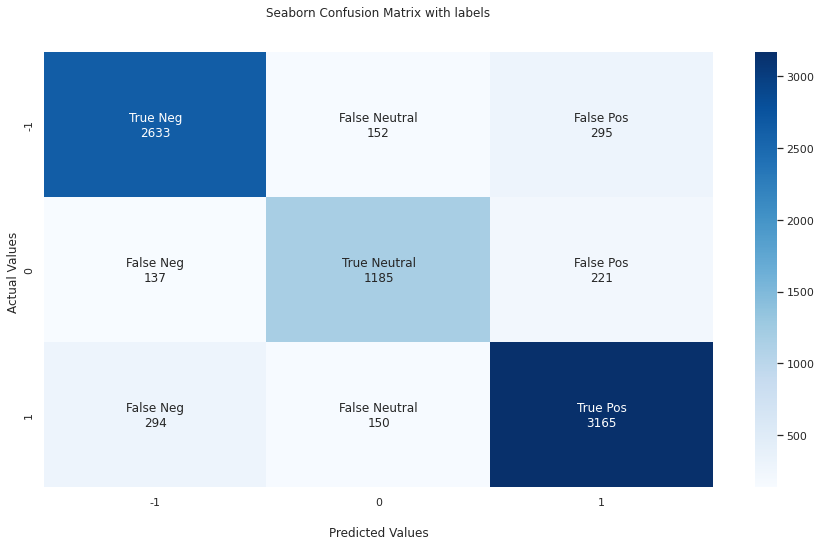

In [103]:
#Confusion matrix for the best model:LinearSVC Grid Model
print("Confusion matrix for the best model-LinearSVC Grid is:")
Improved_cf_multiclass(confusion_matrix(y_test,svc_grid_pred_test) )

##**Conclusion**

###Thus we conclude our project on COVID 19 Tweet Sentiment Analysis. We started by analyzing the dataset to learn more about the variables involved. As a part of Exploratory Data Analysis, we tried to derive different patterns in the data. For building different classification models we used the future 'OriginalTweet' and the target variable 'Sentiment'. By performing tweet cleaning, Tokenization, Lemmatization and Vectorization we prepared the column 'OriginalTweet' for modeling.
###We applied 5 different classification models among which SVM is the best performing model. We did hyperparameter tuning for the best performing model to get an improved score. SVM with 85% accuracy performed well for multinomial classification. 